In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# CHECK WORKIND DIR PATH
import os
# MODIFY SYSTEM PATH
os.chdir('/Users/igorgarbuz/Dev/catlearn')
os.getcwd()

'/Users/igorgarbuz/Dev/catlearn'

In [3]:
# UNCOMMENT BELOW TO SHOW WARNING
# import warnings
# Needed to show warnings in all Jupyter distributions (e.g. VS Code Jupyter implementation)
# warnings.simplefilter(action="default")
# pympler is used for recursive sizeof on datastructures
from pympler.asizeof import asizeof
import random
import numpy as np
import pprint
import itertools
import collections
import graphistry
from pathlib import Path
from multiprocessing import Pool
from statistics import mean
import networkx as nx
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from catlearn.data.dataset import Dataset
from catlearn.graph_utils import (DirectedGraph, clean_selfloops, augment_graph, create_revers_rels)
from catlearn.data.utils import write_file, read_file

In [4]:
# For graph plotting login and create a plotter
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="arreason-labs", password="F49owzNdQHbcEU3p")
plotter = graphistry.bind(source='src', destination='dst', node='nodeid', edge_label='label')

In [5]:
# Format a graph for plotting
def format_for_drawing(G: DirectedGraph, id2entity: dict, id2relation: dict) -> DirectedGraph:
    tmp_rep = list(G.edges(data=True))
    tmp_rep = [(id2entity[src], id2entity[dst], {'label': id2relation[list(rel.keys())[0]]}) for src, dst, rel in tmp_rep]
    return DirectedGraph(tmp_rep)

#?🛠 ? Init plotting tools

In [6]:
def plot_donut(labels, sizes, figsize=(8, 8), title=''):
    plt.figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False)
    central_circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
    fig=plt.gcf()
    fig.gca().add_artist(central_circle)
    plt.axis('equal')
    plt.title(title)
    plt.show()

In [7]:
def plot_bars(values: list, height: list, y_log=False, figsize=(25, 3), title: str='', xtick_rotation=0):
    """Bar plot of list unique numeric values.
    values: list[Union(int, float)]
    """
    plt.figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
    plt.bar(x=values, height=height)
    plt.title(title)
    plt.xticks(rotation=xtick_rotation)
    if y_log:
        plt.yscale('log')
        plt.ylabel('log')
    plt.show()

In [8]:
def plot_bars_uniques(values: list, y_log=False, figsize=(25, 3), title: str=''):
    """Bar plot of list unique numeric values.
    Made using histogram plotter insted of pyplot.bar.
    Has advantage over histogram if data are very sparce
    (e.g. significant distance between bins on numerical scale.)
    Also has advantage over logarithmic X-axis plot, as log scale cannot always compensate
    and must be tuned for sparsity.
    values: list[Union(int, float)]
    """
    x = [str(v) for v in values][::-1]
    n_bins = len(set(values))
    bin_edges = np.arange(n_bins + 1) - 0.5
    plt.figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
    plt.hist(x=x, bins=bin_edges, align='mid')
    plt.title(title)
    plt.xlabel('Length')
    plt.ylabel('Number')
    if y_log:
        plt.yscale('log')
        plt.ylabel('Number (log)')
    plt.show()

## Graphs statistics
1. Show statistics on nodes edges in a matrix for train, valid, test.  
2. Show % and number of nodes / edges from valid, test not in train.
3. Plot graph total nodes edges, with percentage shared train/valid/test and percentage unique for test/valid.  
4. Compute clique index, diameter, centrality, degree histogram


## Alysis of previous results

1. Any directed graph is updated to have equal number of direct and oposed edges.  
2. From (1) any weakly connected graph is equivalent to strongly connected graph.  
3. Longest path is equal to maximal order of connection. Longest path is an NP-hard problem.  
4. Longest path L is alway < than (N - 1), where N is number of vertices.  
5. In any strongly connected graph, by edges composition, longest path is equal to (N - 1).  
6. For (5) to be true, maximal order of composition is equal to (N-2) for worst case : star graph for any pair of vertexes.  
 

# 💿 Import dataset

# Init dataset

In [9]:
# Example WN18 dataset
ds_path = '/Users/igorgarbuz/Dev/catlearn/Datasets/wn18rr/text'

In [10]:
# Explore WN18 dataset
ds = Dataset(path=ds_path, ds_name='wn18', node_vec_dim=10); type(ds)

catlearn.data.dataset.Dataset

In [12]:
ds_train_size = asizeof(ds_train)
ds_valid_size = asizeof(ds_valid)
ds_test_size = asizeof(ds_test)

In [13]:
print(f'Size of train_ds: {ds_train_size/10**6:.2f} Mb')
print(f'Size of valid_ds: {ds_valid_size/10**6:.2f} Mb')
print(f'Size of test_ds:  {ds_test_size/10**6:.2f} Mb')

Size of train_ds: 27.70 Mb
Size of valid_ds: 1.09 Mb
Size of test_ds:  1.13 Mb


In [11]:
# Load dataset into RAM
ds_train = list(ds.train)
ds_valid = list(ds.valid)
ds_test = list(ds.test)

In [ ]:
size_train_mb = asizeof(ds_train)/10**6
size_valid_mb = asizeof(ds_valid)/10**6
size_test_mb = asizeof(ds_test)/10**6

In [ ]:
print(f'size dataset Train {size_train_mb:.2f} Mb')
print(f'size dataset Valid {size_valid_mb:.2f} Mb')
print(f'size dataset Test {size_test_mb:.2f} Mb')

In [14]:
print(f'{"Total unique entities in Train+Valid+Test:":50} {len(ds.entity2id)}')
print(f'{"Total unique relations in Train+Valid+Test:":50} {len(ds.relation2id)}')

Total unique entities in Train+Valid+Test:         41105
Total unique relations in Train+Valid+Test:        11


In [15]:
# Entities separatelly per train/valid/test 
entities_train = [v for tpl in ds_train for v in tpl if not isinstance(v, dict)]
entities_valid = [v for tpl in ds_valid for v in tpl if not isinstance(v, dict)]
entities_test = [v for tpl in ds_test for v in tpl if not isinstance(v, dict)]
# Get uniques
entities_train_unique = set(entities_train)
entities_valid_unique = set(entities_valid)
entities_test_unique = set(entities_test)

In [16]:
# Before extracting relations check graph is NOT multirelational
max_relations_per_edge_train = max([len(list(v.keys())) for tpl in ds_train for v in tpl if isinstance(v, dict)])
max_relations_per_edge_valid = max([len(list(v.keys())) for tpl in ds_valid for v in tpl if isinstance(v, dict)])
max_relations_per_edge_test = max([len(list(v.keys())) for tpl in ds_test for v in tpl if isinstance(v, dict)])
multirelational = True
if (max_relations_per_edge_train == 1
    and max_relations_per_edge_valid == 1
    and max_relations_per_edge_test == 1
):
    print(f'Graph is NOT multirelational.')
    multirelational = False
else:
    print('Graph is multirelational.')
    print('Check further which part of dataset has multiple relations.')

Graph is NOT multirelational.


In [17]:
# Relations separatelly per train/valid/test
relations_train = (list(v.keys()) for tpl in ds_train for v in tpl if isinstance(v, dict))
relations_valid = (list(v.keys()) for tpl in ds_valid for v in tpl if isinstance(v, dict))
relations_test = (list(v.keys()) for tpl in ds_test for v in tpl if isinstance(v, dict))
if not multirelational:
    relations_train = [v[0] for v in relations_train]
    relations_valid = [v[0] for v in relations_valid]
    relations_test = [v[0] for v in relations_test]
else:
    relations_train = [v for lst in relations_train for v in lst]
    relations_valid = [v for lst in relations_valid for v in lst]
    relations_test = [v for lst in relations_test for v in lst]
relations_train_unique = set(relations_train)
relations_valid_unique = set(relations_valid)
relations_test_unique = set(relations_test)

In [18]:
# Uniques relations -- equivalent to graph length
print(f'{"Entities Unique total in Train dataset:":50}{len(entities_train_unique):10}')
print(f'{"Entities Unique total in Valid dataset:":50}{len(entities_valid_unique):10}')
print(f'{"Entities Unique total in Test dataset:":50}{len(entities_test_unique):10}')


Entities Unique total in Train dataset:                40714
Entities Unique total in Valid dataset:                 5174
Entities Unique total in Test dataset:                  5323


In [19]:
print(f'{"Relations total in Train dataset:":50}{len(relations_train):10}')
print(f'{"Relations total in Valid dataset:":50}{len(relations_valid):10}')
print(f'{"Relations total in Test dataset:":50}{ len(relations_test):10}')
# Uniques
print()
assert relations_test_unique == relations_train_unique == relations_valid_unique
print(f'{"Relations Unique total in train dataset:":50}{len(relations_train_unique):10}')

Relations total in Train dataset:                      86835
Relations total in Valid dataset:                       3034
Relations total in Test dataset:                        3134

Relations Unique total in train dataset:                  11


In [20]:
# Average Brancing factor https://en.wikipedia.org/wiki/Branching_factor
# NOTE Compute std and/or histogram
print(f'{"Average Branching factor Train:":40} {len(relations_train)/len(entities_train_unique):<05.3}')
print(f'{"Average Branching factor Valid:":40} {len(relations_valid)/len(entities_valid_unique):<05.3}')
print(f'{"Average Branching factor Test:":40} {len(relations_test)/len(entities_test_unique):<05.3}')

Average Branching factor Train:          2.130
Average Branching factor Valid:          0.586
Average Branching factor Test:           0.589


In [21]:
# Check entities in valid and test not in train set
valid_not_in_train = []
test_not_in_train = []
test_not_in_valid = []
valid_not_in_test = []
def not_in_ds(src: set, ds: set, buffer: list):
    for e in src:
        if not e in ds:
            buffer.append(e)
not_in_ds(src=entities_valid_unique, ds=entities_train_unique, buffer=valid_not_in_train)
not_in_ds(src=entities_test_unique, ds=entities_train_unique, buffer=test_not_in_train)
not_in_ds(src=entities_test_unique, ds=entities_valid_unique, buffer=test_not_in_valid)
not_in_ds(src=entities_valid_unique, ds=entities_test_unique, buffer=valid_not_in_test)

In [22]:
print(f'{"Entities in Valid and not in Train set:":50} {len(valid_not_in_train):5}')
print(f'{"Entities in Test and not in Train set:":50} {len(test_not_in_train):5}')
print(f'{"Entities in test and not in Valid set:":50} {len(test_not_in_valid):5}')
print(f'{"Entities in Valid and not in Test set:":50} {len(valid_not_in_test):5}')
print()
print('In percent:')
print(f'{"Perc. entities in Valid and not in Train set:":50} {len(valid_not_in_train)*100/len(entities_train_unique):5.3} %')
print(f'{"Perc. entities in Test and not in Train set:":50} {len(test_not_in_train)*100/len(entities_train_unique):5.3} %')
print(f'{"Perc. entities in Test and not in Valid set:":50} {len(test_not_in_valid)*100/len(entities_test_unique):5.3} %')
print(f'{"Perc. entities in Valid and not in Test set:":50} {len(valid_not_in_test)*100/len(entities_valid_unique):5.3} %')

Entities in Valid and not in Train set:              205
Entities in Test and not in Train set:               210
Entities in test and not in Valid set:              4299
Entities in Valid and not in Test set:              4150

In percent:
Perc. entities in Valid and not in Train set:      0.504 %
Perc. entities in Test and not in Train set:       0.516 %
Perc. entities in Test and not in Valid set:        80.8 %
Perc. entities in Valid and not in Test set:        80.2 %


### Most of nodes in validation and test sets are present in training set (>99%)

In [23]:
# Example entities
start = random.randint(0, len(ds.entity2id))
slice_length = 5
list(ds.entity2id.items())[start : start + slice_length]

[('help.v.01', 29154),
 ('antelope.n.01', 29155),
 ('draw.v.09', 29156),
 ('gan_jiang.n.01', 29157),
 ('ferrara.n.01', 29158)]

In [26]:
graph_train_size = asizeof(graph_train)
graph_valid_size = asizeof(graph_valid)
graph_test_size = asizeof(graph_test)

In [27]:
print(f'Size of graph Train: {graph_train_size/10**6:.2f} Mb')
print(f'Size of graph Valid: {graph_valid_size/10**6:.2f} Mb')
print(f'Size of graph Test:  {graph_test_size/10**6:.2f} Mb')

Size of graph Train: 55.02 Mb
Size of graph Valid: 4.92 Mb
Size of graph Test:  5.05 Mb


In [24]:
# Relations to id
ds.relation2id

{'_instance_hypernym': 0,
 '_hypernym': 1,
 '_derivationally_related_form': 2,
 '_synset_domain_topic_of': 3,
 '_similar_to': 4,
 '_member_meronym': 5,
 '_has_part': 6,
 '_member_of_domain_usage': 7,
 '_verb_group': 8,
 '_also_see': 9,
 '_member_of_domain_region': 10}

# 🧱 Create directed graphs

In [25]:
graph_train = DirectedGraph(ds_train)
graph_valid = DirectedGraph(ds_valid)
graph_test = DirectedGraph(ds_test)

In [ ]:
graph_train_size = asizeof(graph_train)
graph_valid_size = asizeof(graph_valid)
graph_test_size = asizeof(graph_test)

In [ ]:
print(f'Graph size Train: {graph_train_size/10**6:.2f} Mb')
print(f'Graph size Valid: {graph_valid_size/10**6:.2f} Mb')
print(f'Graph size Test: {graph_test_size/10**6:.2f} Mb')

Note: Graph representation in memory roughtly doubled compared with the list of triples.
Expected change for adjacent list reresentation, where 

In [28]:
print(f'{"Graph length (N Nodes in) Train:":40}{len(graph_train)}')
print(f'{"Graph length (N Nodes in) Valid:":40}{len(graph_valid)}')
print(f'{"Graph length (N Nodes in) Test:":40}{len(graph_test)}')
print()
print(f'{"Edges in Train:":40}{len(graph_train.edges)}')
print(f'{"Edges in Valid:":40}{len(graph_valid.edges)}')
print(f'{"Edges in Test:":40}{len(graph_test.edges)}')

Graph length (N Nodes in) Train:        40714
Graph length (N Nodes in) Valid:        5174
Graph length (N Nodes in) Test:         5323

Edges in Train:                         86726
Edges in Valid:                         3034
Edges in Test:                          3134


## 🧼 Clean self-loops (edge has the same node at both ends) 
u<>u

In [29]:
clean_selfloops(graph_train)
clean_selfloops(graph_valid)
clean_selfloops(graph_test)


Following 7 selfloop edge(s) are found:
[(30440, 30440), (24410, 24410), (18188, 18188), (24568, 24568), (10143, 10143), (9618, 9618), (25511, 25511)]
7 selfloop edges are removed.
Following 0 isolate(s) are found:
[]
0 isolates are removed.

Following 2 selfloop edge(s) are found:
[(10060, 10060), (6202, 6202)]
2 selfloop edges are removed.
Following 2 isolate(s) are found:
[10060, 6202]
2 isolates are removed.

Following 0 selfloop edge(s) are found:
[]
0 selfloop edges are removed.
Following 0 isolate(s) are found:
[]
0 isolates are removed.


### As expected, graph length is equal to number of unique nodes, computed earlier

In [30]:
# Shorter way to get graph statistics.
# In/Out degre is equivalent to branching factor computed earlier -- average number of edges per node
print(nx.info(graph_train))
# print(nx.info(graph_valid))
# print(nx.info(graph_test))

Name: 
Type: DirectedGraph
Number of nodes: 40714
Number of edges: 86719
Average in degree:   2.1300
Average out degree:   2.1300


# Vertex statistics

## Let's plot degree distribution per node
Degree of a node -- number of edges per node 
In addition, check how many nodes in train are connected to the same nodes in valid and test (basically check edges cross-talk).
Do cross-talk w/o labels

In [31]:
vertex_degrees_train = sorted([len(graph_train[node]) for node in graph_train], reverse=True)
vertex_degrees_valid = sorted([len(graph_valid[node]) for node in graph_valid], reverse=True)
vertex_degrees_test = sorted([len(graph_test[node]) for node in graph_test], reverse=True)

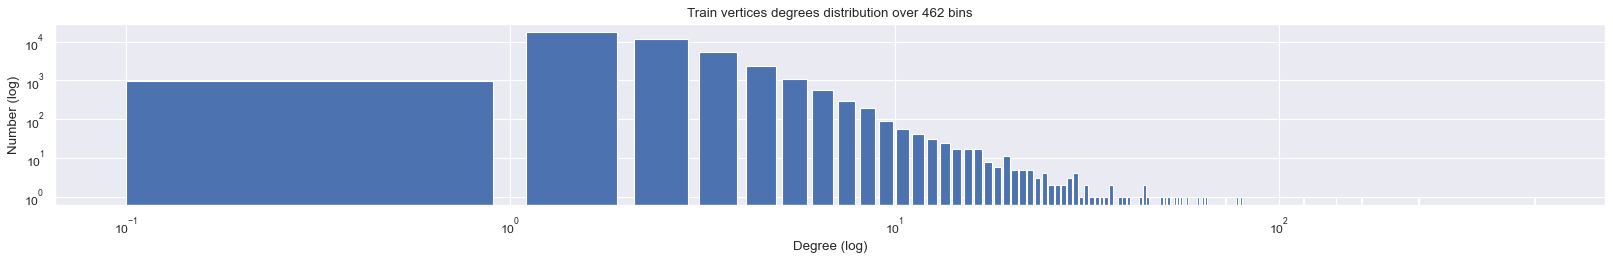

In [32]:
slice_first = 0
slice_last = -1
bins=max(vertex_degrees_train[slice_first:slice_last])
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(vertex_degrees_train[slice_first:slice_last], bins=bins, rwidth=0.8)
plt.title(f'Train vertices degrees distribution over {bins} bins')
plt.xlabel('Degree (log)')
plt.ylabel('Number (log)')
plt.yscale('log')
plt.xscale('log')
plt.show()

It can be seen that histogram does not give a good overview, especially for all range of values.  
We have to either slice the list to cut off first ~10 largest, or to try to plot in log space.  
Current plot is in log in both, x and y.  Try to comment out x or y log to observe differences in real scales.  
  
Even after tuning the log space, it doesn't give the granularity necessary to understand the data.  
Alternative would be to count the unique values and plot the distribution without intermediate values that are absent.  
To remind, histogram is a distribution over a continuous range. A simple 'trick' to compute it over discrete bins would be
to convert list of ints to list of strs.

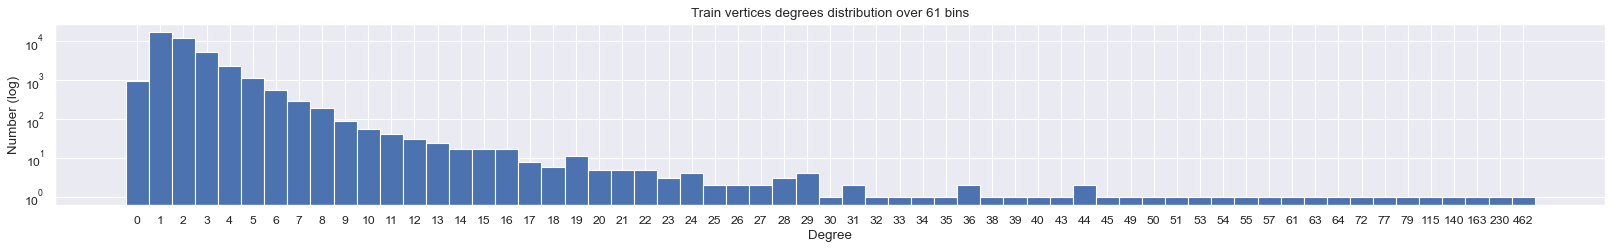

In [33]:
# Bar plot of degrees distribution per node
# NOTE It's not a histogram as bins are calculated over discret valus
vertex_degrees_train_str = [str(v) for v in vertex_degrees_train][::-1]
n_bins = len(set(vertex_degrees_train_str))
bin_edges = np.arange(n_bins + 1) - 0.5
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.hist(x=vertex_degrees_train_str, bins=bin_edges, align='mid')
plt.title(f'Train vertices degrees distribution over {n_bins} bins')
plt.xlabel('Degree')
plt.ylabel('Number (log)')
plt.yscale('log')
plt.show()

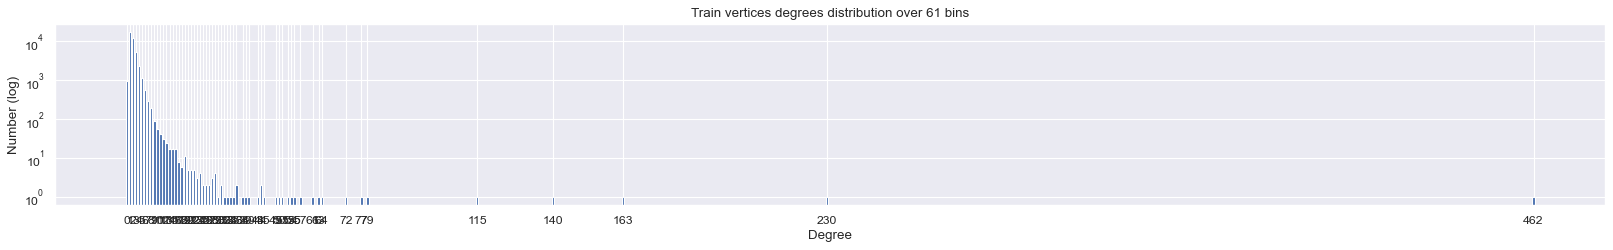

In [34]:
# Same as above, but with right x-axis scale
vertex_degrees_dist = collections.Counter(vertex_degrees_train)
x = vertex_degrees_dist.keys()
y = vertex_degrees_dist.values()
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x=x, height=y, align='center')
plt.title(f'Train vertices degrees distribution over {len(x)} bins')
plt.xlabel('Degree')
plt.ylabel('Number (log)')
plt.yscale('log')
plt.xticks(list(x))
plt.show()

Significant quantity of nodes are disconnected from the graph. Their re-connection is only possible if there is some semantic information in the words.  

Curiously, in training set there are super connencted nodes with 400+ and 200+ connections

In [35]:
# super_connected_nodes = {ds.id2entity[node] : len(graph_train[node]) for node in graph_train if len(graph_train[node]) > 50}
min_n_out_edges = 50
nodes_super_out_connctions = ((ds.id2entity[node], len(graph_train[node])) for node in graph_train if len(graph_train[node]) > min_n_out_edges)
nodes_super_out_connctions = sorted(nodes_super_out_connctions, key=lambda item: item[1], reverse=True)
print(f'Super connected nodes:')
for k, v in nodes_super_out_connctions:
    print(f'{k:30} {v}')

Super connected nodes:
united_kingdom.n.01            462
trade_name.n.01                230
compositae.n.01                163
united_states.n.01             140
plural.n.01                    115
slang.n.02                     79
papilionoideae.n.01            77
orchidaceae.n.01               72
germany.n.01                   64
china.n.01                     63
colloquialism.n.01             61
france.n.01                    57
africa.n.01                    55
perciformes.n.01               54
gramineae.n.01                 53
cruciferae.n.01                51


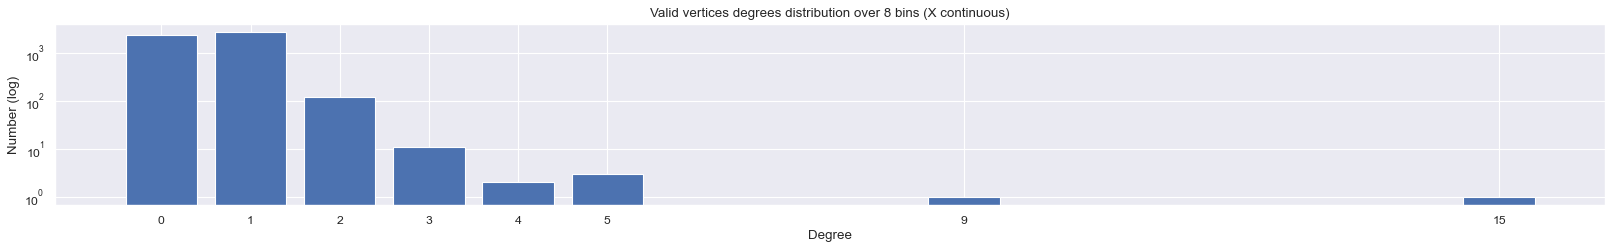

In [36]:
vertex_degrees_dist = collections.Counter(vertex_degrees_valid)
x = vertex_degrees_dist.keys()
y = vertex_degrees_dist.values()
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x=x, height=y, align='center')
plt.title(f'Valid vertices degrees distribution over {len(x)} bins (X continuous)')
plt.xlabel('Degree')
plt.ylabel('Number (log)')
plt.yscale('log')
plt.xticks(list(x))
plt.show()

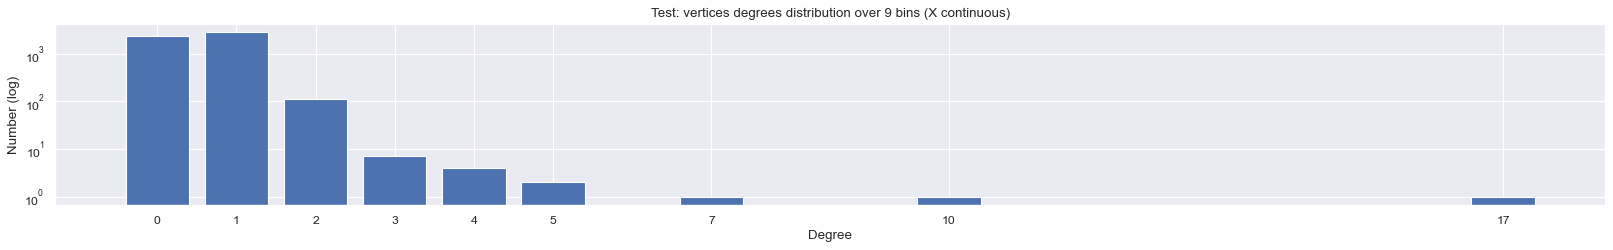

In [37]:
vertex_degrees_dist = collections.Counter(vertex_degrees_test)
x = vertex_degrees_dist.keys()
y = vertex_degrees_dist.values()
plt.figure(num=None, figsize=(25, 3), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x=x, height=y, align='center')
plt.title(f'Test: vertices degrees distribution over {len(x)} bins (X continuous)')
plt.xlabel('Degree')
plt.ylabel('Number (log)')
plt.yscale('log')
plt.xticks(list(x))
plt.show()

Finally, let's represent the graph above as a table.

In [38]:
def counter_degrees(vertex_list: list) -> list:
    return dict(sorted(collections.Counter(vertex_list).items(), key=lambda x: x[0]))

In [39]:
# Train set 
uniques_degrees_count_train = counter_degrees(vertex_degrees_train)
uniques_degrees_count_valid = counter_degrees(vertex_degrees_valid)
uniques_degrees_count_test = counter_degrees(vertex_degrees_test)

In [40]:
# NOTE: Uncoment to print out degree count
dct = None
# dct = uniques_degrees_count_train
# dct = uniques_degrees_count_valid
dct = uniques_degrees_count_test
print('deg, number')
print('-----------')
pprint.pprint(dct)

deg, number
-----------
{0: 2365, 1: 2831, 2: 111, 3: 7, 4: 4, 5: 2, 7: 1, 10: 1, 17: 1}


In [41]:
# Check that sum of all connections (degrees) count is equal to graph's length
assert len(graph_train) == sum(uniques_degrees_count_train.values())
assert len(graph_valid) == sum(uniques_degrees_count_valid.values())
assert len(graph_test) == sum(uniques_degrees_count_test.values())

In [42]:
prc_nodes_no_connection_train = uniques_degrees_count_train[0] * 100 / len(graph_train)
prc_nodes_no_connection_valid = uniques_degrees_count_valid[0] * 100 / len(graph_valid)
prc_nodes_no_connection_test = uniques_degrees_count_test[0] * 100 / len(graph_test)

In [43]:
prc_nodes_one_connection_train = uniques_degrees_count_train[1] * 100 / len(graph_train)
prc_nodes_one_connection_valid = uniques_degrees_count_valid[1] * 100 / len(graph_valid)
prc_nodes_one_connection_test = uniques_degrees_count_test[1] * 100 / len(graph_test)

In [44]:
prc_nodes_two_connections_train = uniques_degrees_count_train[2] * 100 / len(graph_train)
prc_nodes_two_connections_valid = uniques_degrees_count_valid[2] * 100 / len(graph_valid)
prc_nodes_two_connections_test = uniques_degrees_count_test[2] * 100 / len(graph_test)

In [45]:
prc_nodes_more_than_two_connections_train = 100 - prc_nodes_no_connection_train - prc_nodes_one_connection_train - prc_nodes_two_connections_train
prc_nodes_more_than_two_connections_valid =  100 - prc_nodes_no_connection_valid - prc_nodes_one_connection_valid - prc_nodes_two_connections_valid
prc_nodes_more_than_two_connections_test =  100 - prc_nodes_no_connection_test - prc_nodes_one_connection_test - prc_nodes_two_connections_test

In [46]:
first_col_width = 42
print(f'{"Prc of nodes without connection Train:":{first_col_width}} {prc_nodes_no_connection_train:.3} %')
print(f'{"Prc of nodes without connection Valid:":{first_col_width}} {prc_nodes_no_connection_valid:.3} %')
print(f'{"Prc of nodes without connection Test:":{first_col_width}} {prc_nodes_no_connection_test:.3} %')

Prc of nodes without connection Train:     2.36 %
Prc of nodes without connection Valid:     44.9 %
Prc of nodes without connection Test:      44.4 %


It can be concluded that Test and Validation sets are very sparse, with almost half of all vertexes been not connected.  
On the other hand, train dataset is well connected, with ~70% of all nodes having 1 or 2 Out connections.

In [47]:
first_col_width = 42
print(f'{"Prc of nodes one connection Train:":{first_col_width}} {prc_nodes_one_connection_train:.3} %')
print(f'{"Prc of nodes one connection Valid:":{first_col_width}} {prc_nodes_one_connection_valid:.3} %')
print(f'{"Prc of nodes one connection Test:":{first_col_width}} {prc_nodes_one_connection_test:.3} %')

Prc of nodes one connection Train:         42.9 %
Prc of nodes one connection Valid:         52.4 %
Prc of nodes one connection Test:          53.2 %


In [48]:
first_col_width = 42
print(f'{"Prc of nodes two connections Train:":{first_col_width}} {prc_nodes_two_connections_train:.3} %')
print(f'{"Prc of nodes two connections Valid:":{first_col_width}} {prc_nodes_two_connections_valid:.3} %')
print(f'{"Prc of nodes two connections Test:":{first_col_width}} {prc_nodes_two_connections_test:.3} %')

Prc of nodes two connections Train:        29.4 %
Prc of nodes two connections Valid:        2.32 %
Prc of nodes two connections Test:         2.09 %


In [49]:
first_col_width = 52
print(f'{"Prc of nodes more than two connections Train:":{first_col_width}} {prc_nodes_more_than_two_connections_train:.3} %')
print(f'{"Prc of nodes more than two connections Test:":{first_col_width}} {prc_nodes_more_than_two_connections_valid:.3} %')
print(f'{"Prc of nodes more than two connections Valid:":{first_col_width}} {prc_nodes_more_than_two_connections_test:.3} %')

Prc of nodes more than two connections Train:        25.4 %
Prc of nodes more than two connections Test:         0.348 %
Prc of nodes more than two connections Valid:        0.301 %


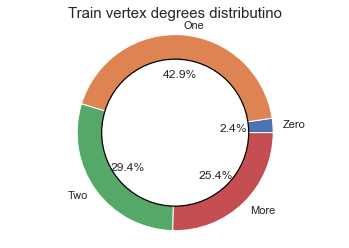

In [50]:
labels = ['Zero', 'One', 'Two', 'More']
sizes = [prc_nodes_no_connection_train, prc_nodes_one_connection_train, prc_nodes_two_connections_train, prc_nodes_more_than_two_connections_train]
explode=(0,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False)
central_circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig=plt.gcf()
fig.gca().add_artist(central_circle)
plt.axis('equal')
plt.title(f'Train vertex degrees distributino', fontsize=15)
plt.show()

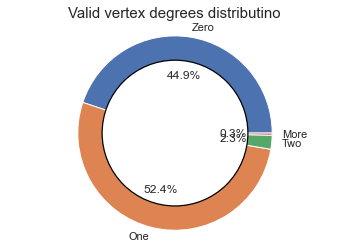

In [51]:
labels = ['Zero', 'One', 'Two', 'More']
sizes = [prc_nodes_no_connection_valid, prc_nodes_one_connection_valid, prc_nodes_two_connections_valid, prc_nodes_more_than_two_connections_valid]
explode=(0,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False)
central_circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig=plt.gcf()
fig.gca().add_artist(central_circle)
plt.axis('equal')
plt.title(f'Valid vertex degrees distributino', fontsize=15)
plt.show()

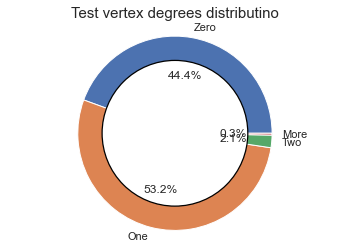

In [52]:
labels = ['Zero', 'One', 'Two', 'More']
sizes = [prc_nodes_no_connection_test, prc_nodes_one_connection_test, prc_nodes_two_connections_test, prc_nodes_more_than_two_connections_test]
explode=(0,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False)
central_circle = plt.Circle((0,0), 0.75, color='black', fc='white', linewidth=1.25)
fig=plt.gcf()
fig.gca().add_artist(central_circle)
plt.axis('equal')
plt.title(f'Test vertex degrees distributino', fontsize=15)
plt.show()

# Relations statistics

In [53]:
relations_train = [list(rel.keys())[0] for _, _, rel in ds_train]
relations_train_count = collections.Counter(relations_train)
tmp = {ds.id2relation[key]: val for key, val in relations_train_count.items()}
relations_train_count_str = dict(sorted(tmp.items(), key=lambda x: x[1], reverse=True))

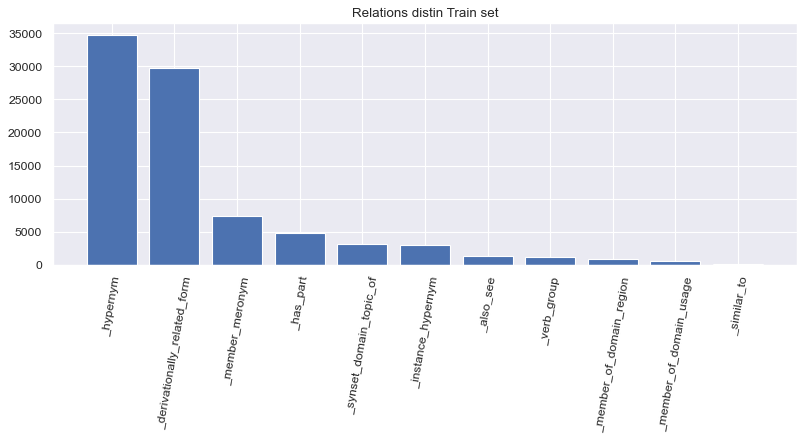

In [54]:
plot_bars(values=relations_train_count_str.keys(), height=relations_train_count_str.values(), y_log=False, figsize=(12, 4), title='Relations distin Train set', xtick_rotation=80)

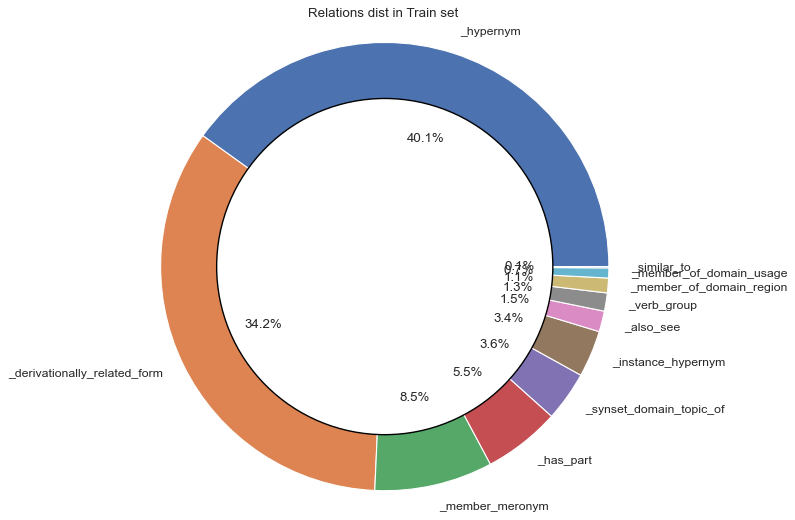

In [55]:
plot_donut(labels=relations_train_count_str.keys(), sizes=relations_train_count_str.values(), figsize=(8,8), title='Relations dist in Train set')

In [56]:
relations_valid = [list(rel.keys())[0] for _, _, rel in ds_valid]
relations_valid_count = collections.Counter(relations_valid)
tmp = {ds.id2relation[key]: val for key, val in relations_valid_count.items()}
relations_valid_count_str = dict(sorted(tmp.items(), key=lambda x: x[1], reverse=True))

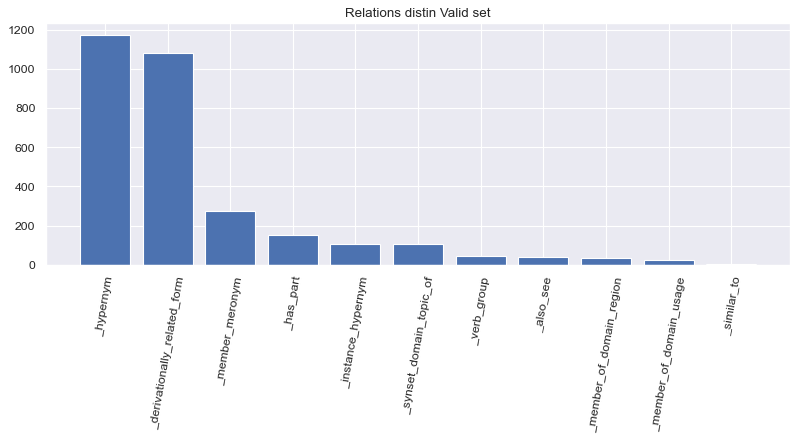

In [57]:
plot_bars(values=relations_valid_count_str.keys(), height=relations_valid_count_str.values(), y_log=False, figsize=(12, 4), title='Relations distin Valid set', xtick_rotation=80)

In [58]:
relations_test = [list(rel.keys())[0] for _, _, rel in ds_test]
relations_test_count = collections.Counter(relations_test)
tmp = {ds.id2relation[key]: val for key, val in relations_test_count.items()}
relations_test_count_str = dict(sorted(tmp.items(), key=lambda x: x[1], reverse=True))

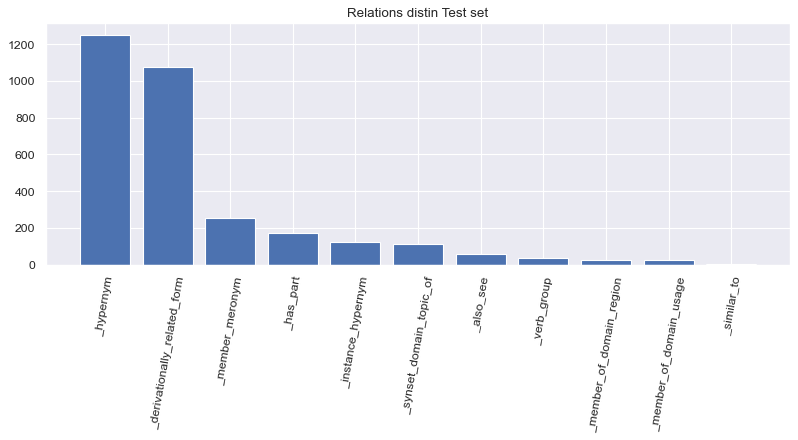

In [59]:
plot_bars(values=relations_test_count_str.keys(), height=relations_test_count_str.values(), y_log=False, figsize=(12, 4), title='Relations distin Test set', xtick_rotation=80)

# Compute Betweenness centrality
Number (fraction of all-pairs shortest paths) of shortest paths through each node  
https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html

In [60]:
# Equivalent to nx.betweenness_centrality() with multithreading
def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x

def betweenness_centrality_parallel(G, processes=os.cpu_count()):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            [None] * num_chunks,
        ),
    )
    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

### If betweenness alraedy computed load them

In [61]:
stats_path = Path(os.getcwd())/'Datasets'/'wn18rr'/'stats'
if not os.path.isdir(stats_path):
    os.mkdir(stats_path)
btwnss_files = [
    stats_path/'betweenness_train.txt',
    stats_path/'betweenness_valid.txt',
    stats_path/'betweenness_test.txt'
]
# Read files if present in the directory
bt_files = [None] * 3
bt_train, bt_valid, bt_test = None, None, None
for idx, file in enumerate(btwnss_files):
    if os.path.isfile(file):
        bt_files[idx] = (line.split('\t') for line in read_file(file))
        bt_files[idx] = [(name, float(value)) for name, value in bt_files[idx]]
bt_train, bt_valid, bt_test = bt_files
bt_train_text, bt_valid_text, bt_test_text = bt_train, bt_valid, bt_test

In [62]:
%%time
# Compute betweenness centrality -- number of shortest paths through each node: https://en.wikipedia.org/wiki/Betweenness_centrality
# NOTE for graph_train time >60 min. Uncoment if dispose enough time / resources
if not bt_train:
    %time bt_train = betweenness_centrality_parallel(graph_train)
    bt_train_text = ((ds.id2entity[k], v) for k, v in bt_train.items())
    bt_train_text = sorted(bt_train_text, key=lambda tpl: tpl[1], reverse=True)
if not bt_valid:
    %time bt_valid = betweenness_centrality_parallel(graph_valid)
    bt_valid_text = ((ds.id2entity[k], v) for k, v in bt_valid.items())
    bt_valid_text = sorted(bt_valid_text, key=lambda tpl: tpl[1], reverse=True)
if not bt_test:
    %time bt_test = betweenness_centrality_parallel(graph_test)
    bt_test_text = ((ds.id2entity[k], v) for k, v in bt_test.items())
    bt_test_text = sorted(bt_test_text, key=lambda tpl: tpl[1], reverse=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


## Save betweennees calculation if doesn't exist

In [63]:
# Define path to store wn18 betweenness calculations
stats_path = Path(os.getcwd())/'Datasets'/'wn18rr'/'stats'
if not os.path.isdir(stats_path):
    os.mkdir(stats_path)
write_file(path=btwnss_files[0], to_file=dict(bt_train_text))
write_file(path=btwnss_files[1], to_file=dict(bt_valid_text))
write_file(path=btwnss_files[2], to_file=dict(bt_test_text))

## Explore most central nodes

In [64]:
print(f'Most central in Train set:\n')
n_most_central = 40
for k, v in bt_train_text[:n_most_central]:
    print(f'{k:30} {v:.3}')

Most central in Train set:

person.n.01                    0.0565
put.v.01                       0.029
human_body.n.01                0.0282
body.n.01                      0.0281
genus.n.02                     0.0198
collection.n.01                0.0192
travel.v.01                    0.0187
biology.n.01                   0.0184
roll_up.v.02                   0.0166
plant.n.02                     0.0162
change.v.01                    0.0153
act.n.02                       0.0152
plant.v.01                     0.0146
make.v.03                      0.0141
scientist.n.01                 0.0135
classify.v.01                  0.0124
accumulate.v.02                0.0123
arthropod.n.01                 0.0119
arthropodal.a.01               0.0117
arthropoda.n.01                0.0117
biologist.n.01                 0.0115
causal_agent.n.01              0.0114
accumulation.n.03              0.011
act.v.01                       0.0105
vascular_plant.n.01            0.00997
insecta.n.01           

In [65]:
print(f'Most central in Valid set:\n')
n_most_central = 20
for k, v in bt_valid_text[:n_most_central]:
    print(f'{k:30} {v:.2}')

Most central in Valid set:

herb.n.01                      1e-06
vascular_plant.n.01            5.6e-07
law.n.01                       4.5e-07
chemistry.n.01                 2.6e-07
transgress.v.01                2.2e-07
decorate.v.01                  1.5e-07
fortification.n.02             1.5e-07
tree.n.01                      1.5e-07
legal_document.n.01            1.5e-07
offensive.a.05                 1.5e-07
opinion.n.01                   1.5e-07
create_by_mental_act.v.01      1.5e-07
art.n.03                       1.1e-07
turn_back.v.05                 1.1e-07
affirm.v.02                    1.1e-07
think.v.01                     1.1e-07
car.n.01                       1.1e-07
viola.n.01                     1.1e-07
shaking.n.02                   1.1e-07
strengthen.v.01                1.1e-07


In [66]:
print(f'Most central in Test set:\n')
n_most_central = 20
for k, v in bt_test_text[:n_most_central]:
    print(f'{k} : {v:.2}')

Most central in Test set:

city.n.01 : 8.5e-07
military.n.01 : 3.9e-07
travel.v.01 : 3.2e-07
attach.v.01 : 1.8e-07
hit.v.03 : 1.8e-07
investigation.n.02 : 1.4e-07
categorization.n.03 : 1.4e-07
insert.v.01 : 1.4e-07
representation.n.02 : 1.4e-07
clothing.n.01 : 1.4e-07
program.n.07 : 1.1e-07
investigate.v.02 : 1.1e-07
river.n.01 : 1.1e-07
surprise.n.02 : 1.1e-07
cannulate.v.01 : 1.1e-07
distinguish.v.01 : 1.1e-07
tabulation.n.02 : 1.1e-07
crime.n.01 : 7.1e-08
arrange.v.01 : 7.1e-08
placement.n.01 : 7.1e-08


In [67]:
# top_n = 50
# bins=10
# plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
# plt.hist(dict(bt_train_text[:top_n]).values(), bins=bins, rwidth=0.8)
# plt.title(f'Train ds: Betweenness top {top_n} nodes')
# plt.xlabel('Betweenness')
# plt.ylabel('Occurances')
# plt.show()

In [68]:
# top_n = 10
# bins=10
# plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
# plt.hist(dict(bt_valid_text[:top_n]).values(), bins=10, rwidth=0.8)
# plt.title(f'Valid ds: Betweenness top {top_n} nodes')
# plt.xlabel('Betweenness')
# plt.ylabel('Occurances')
# plt.show()

In [69]:
# top_n = 10
# bins=10
# plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
# plt.hist(dict(bt_test_text[:top_n]).values(), bins=bins, rwidth=0.8)
# plt.title(f'Test ds: Betweenness top {top_n} nodes')
# plt.xlabel('Betweenness')
# plt.ylabel('Occurances')
# plt.show()

# Compute Diameter
Diameter can only be computed on strongly connected graph (path exist entween u, v for all pairs of nodes).
Proposed strategy: divide the graph on strongly-connected subgraphs.
Compute the diameter for each subgraph. Consider dataset graph diameter as a maximal diameter of all subgraphs.  
Single node is considered a strongly connected graph in networkx.
Max diameter shows the maximal possible order of connectivity. It gives the maximal number of edges (relations) to be composed to connect two nodes.  
  
Diameter cannot be computed for weakly connected graph (no disconnected nodes, but due to directiveness it's not possible to find a path for all pairs of nodes).
Diameter can be computed for directed and unidirected graphs. Only directional graph can be weakly connected. Unidirectional graph is always strongly-connected or disconnected.  
  
It is interesting to re-consider input directional graph as unidirectional. 
X2 oposite connections may exist (a<=>b), in graph theory for a->b<-c: `a` is Not connected to `c`.
Hovewer, for knowledge graphs and reasoning, a and c can be considered as connected because they have a common ancestor.
E.g. BMW<-hyponym-Vehicle-Hyponym->Truck. Truck and BMW are connected by e.g <-Related-> or <-similar_to-> relation.  
Any directional knowledge/logical graph can be augmented with oposit relations for all nodes. Thus it becomes equivalent to unidirectional to compute diameter, shortest path, etc.

### Convert each dataset to a list of subgraphs, either weakly or strongly connected

In [70]:
%%time
# weakly connected components return a directed graph of minimal length 2
# strongly connected components returns a directed graph of minimal length 1 (single node is considered a graph)
%time sub_graphs_weakly_train = sorted([graph_train.subgraph(nodes) for nodes in nx.weakly_connected_components(graph_train)], key=lambda x: len(x), reverse=True)
%time sub_graphs_weakly_valid = sorted([graph_valid.subgraph(nodes) for nodes in nx.weakly_connected_components(graph_valid)], key=lambda x: len(x), reverse=True)
%time sub_graphs_weakly_test = sorted([graph_test.subgraph(nodes) for nodes in nx.weakly_connected_components(graph_test)], key=lambda x: len(x), reverse=True)
%time sub_graphs_strongly_train = sorted([graph_train.subgraph(nodes) for nodes in nx.strongly_connected_components(graph_train)], key=lambda x: len(x), reverse=True)
%time sub_graphs_strongly_valid = sorted([graph_valid.subgraph(nodes) for nodes in nx.strongly_connected_components(graph_valid)], key=lambda x: len(x), reverse=True)
%time sub_graphs_strongly_test = sorted([graph_test.subgraph(nodes) for nodes in nx.strongly_connected_components(graph_test)], key=lambda x: len(x), reverse=True)

CPU times: user 147 ms, sys: 5.27 ms, total: 152 ms
Wall time: 154 ms
CPU times: user 58.1 ms, sys: 2.35 ms, total: 60.5 ms
Wall time: 61.1 ms
CPU times: user 62.8 ms, sys: 3.99 ms, total: 66.8 ms
Wall time: 68.1 ms
CPU times: user 1.1 s, sys: 38.7 ms, total: 1.14 s
Wall time: 1.15 s
CPU times: user 115 ms, sys: 7.3 ms, total: 122 ms
Wall time: 124 ms
CPU times: user 392 ms, sys: 12.5 ms, total: 405 ms
Wall time: 409 ms
CPU times: user 1.88 s, sys: 70.7 ms, total: 1.95 s
Wall time: 1.98 s


In [71]:
# NOTE: Sorting of lengths here is not necessary, as graphs have already been sorted by length. It's kept for verbosity of keeping lists in decreasing order 
sub_graphs_weakly_train_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_weakly_train], reverse=True)
sub_graphs_weakly_valid_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_weakly_valid], reverse=True)
sub_graphs_weakly_test_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_weakly_test], reverse=True)
sub_graphs_strongly_train_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_strongly_train], reverse=True)
sub_graphs_strongly_valid_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_strongly_valid], reverse=True)
sub_graphs_strongly_test_lengths = sorted([sub.number_of_nodes() for sub in sub_graphs_strongly_test], reverse=True)

In [72]:
# Weakly connected subgraph tend to have bigger diameter, but there is much smaller quantity of them
# The oposite is observed for strongly connected subgraphs
print(f'{"Number of sub-graphs Weakly Train: ":40}{len(sub_graphs_weakly_train):>5}')
print(f'{"Number of sub-graphs Weakly Valid: ":40}{len(sub_graphs_weakly_valid):>5}')
print(f'{"Number of sub-graphs Weakly Test: ":40}{len(sub_graphs_weakly_test):>5}')
print()
print(f'{"Number of sub-graphs Strongly Train: ":40}{len(sub_graphs_strongly_train):>5}')
print(f'{"Number of sub-graphs Strongly Valid: ":40}{len(sub_graphs_strongly_valid):>5}')
print(f'{"Number of sub-graphs Strongly Test: ":40}{len(sub_graphs_strongly_test):>5}')

Number of sub-graphs Weakly Train:         51
Number of sub-graphs Weakly Valid:       2159
Number of sub-graphs Weakly Test:        2203

Number of sub-graphs Strongly Train:    23511
Number of sub-graphs Strongly Valid:     5153
Number of sub-graphs Strongly Test:      5308


### For comparaison: total graph lengths below

|Name|Value|
|:---|---:|
|Entities Unique total in Train dataset:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;| 40714|  
|Entities Unique total in Valid dataset:|  5174|
|Entities Unique total in Test dataset:|   5323|  


In [73]:
print(f'Min length of Weakly connected graph is:            {min(sub_graphs_weakly_train_lengths)}')
print(f'Min length of Strongly connected graph is:          {min(sub_graphs_strongly_train_lengths)}')


Min length of Weakly connected graph is:            2
Min length of Strongly connected graph is:          1


In [74]:
print(f'Sum of all nodes in the Weakly connected subgraph is {sum(sub_graphs_weakly_train_lengths)}')

Sum of all nodes in the Weakly connected subgraph is 40714


Sum of all nodes in weakly connected graph is equal to total number of nodes in the graph that means there is no node without a connection.  
    
We can check it by converting train grain to unidirectional and verifying there is no node without and edge.  

In [75]:
first_col_with = 60
print(f'{"Max length of sub-graph Weakly Train: ":{first_col_with}}{max(sub_graphs_weakly_train_lengths):>7}')
print(f'{"Max length of sub-graph Weakly Valid: ":{first_col_with}}{max(sub_graphs_weakly_valid_lengths):>7}')
print(f'{"Max length of sub-graph Weakly Test: ":{first_col_with}}{max(sub_graphs_weakly_test_lengths):>7}')
print()
print(f'{"Max length of sub-graph Strongly Train: ":{first_col_with}}{max(sub_graphs_strongly_train_lengths):>7}')
print(f'{"Max length of sub-graph Strongly Valid: ":{first_col_with}}{max(sub_graphs_strongly_valid_lengths):>7}')
print(f'{"Max length of sub-graph Strongly Test: ":{first_col_with}}{max(sub_graphs_strongly_test_lengths):>7}')

Max length of sub-graph Weakly Train:                         40586
Max length of sub-graph Weakly Valid:                            20
Max length of sub-graph Weakly Test:                             26

Max length of sub-graph Strongly Train:                       13806
Max length of sub-graph Strongly Valid:                           2
Max length of sub-graph Strongly Test:                            3


There are ```961``` (~2%) nodes without edges in Train dataset.  
All other nodes have at least one connection.  
Max length of Weakly connected subgraph 

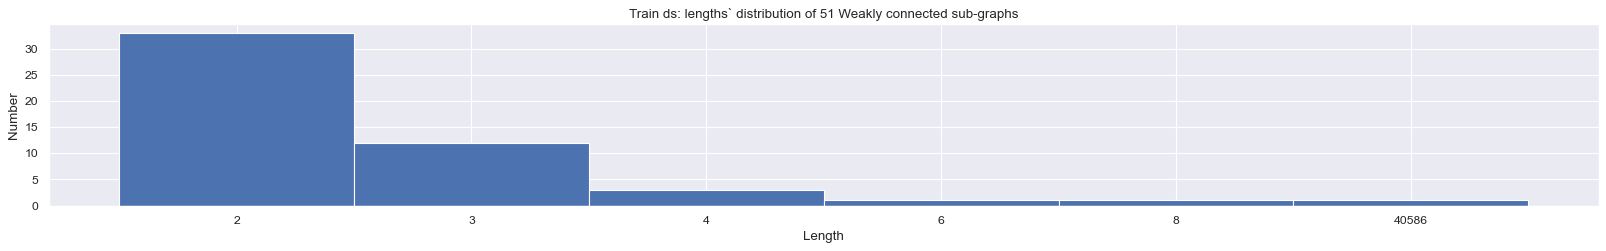

In [76]:
plot_bars_uniques(sub_graphs_weakly_train_lengths, y_log=False, title=f'Train ds: lengths` distribution of {len(sub_graphs_weakly_train_lengths)} Weakly connected sub-graphs')

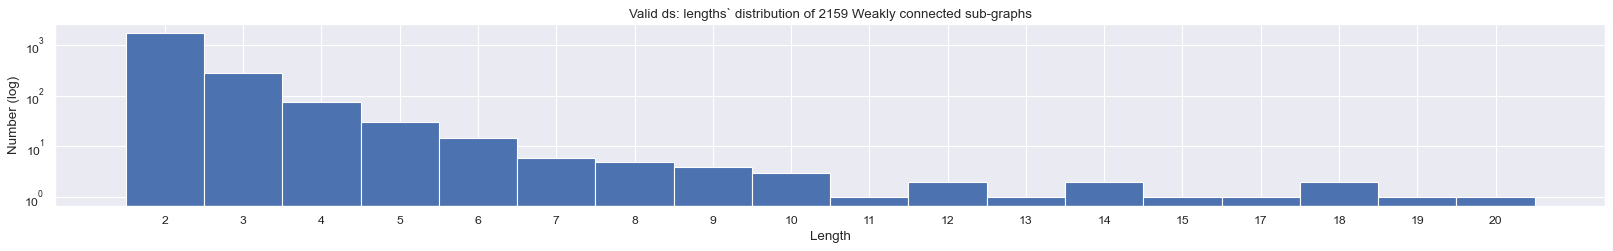

In [77]:
plot_bars_uniques(sub_graphs_weakly_valid_lengths, y_log=True, title=f'Valid ds: lengths` distribution of {len(sub_graphs_weakly_valid_lengths)} Weakly connected sub-graphs')

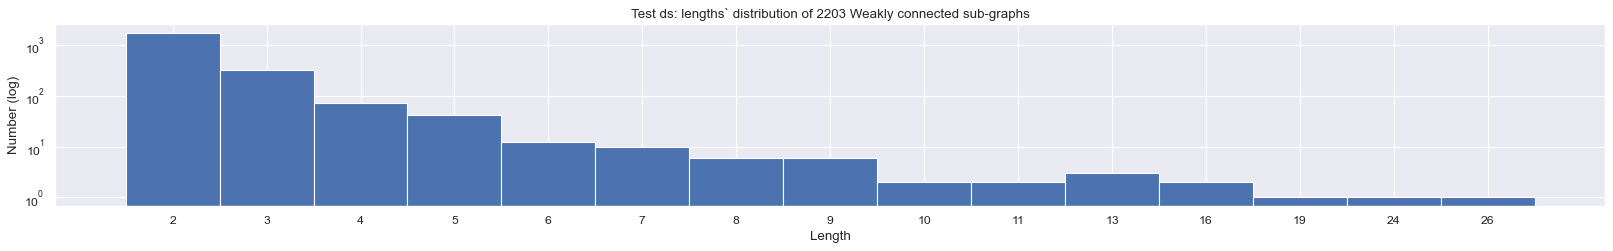

In [78]:
plot_bars_uniques(sub_graphs_weakly_test_lengths, y_log=True, title=f'Test ds: lengths` distribution of {len(sub_graphs_weakly_test_lengths)} Weakly connected sub-graphs')

### Strongly connected subgraphs set contain many length 1 subgraphs -- single node without edges.
Particularly for Validation and Test sets. It's expected since a node is a minimal atomic graph component.
Given a graph (1->2), it has to strongly-connected subgraphs (1) and (2). 

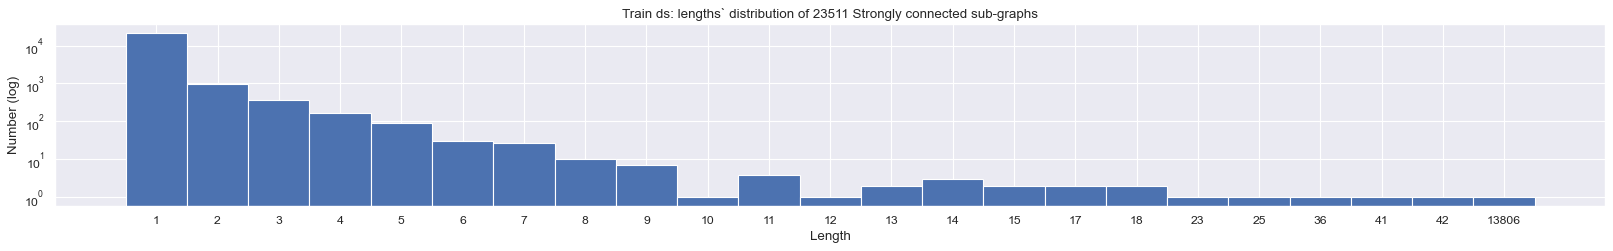

In [79]:
plot_bars_uniques(sub_graphs_strongly_train_lengths, y_log=True, title=f'Train ds: lengths` distribution of {len(sub_graphs_strongly_train_lengths)} Strongly connected sub-graphs')

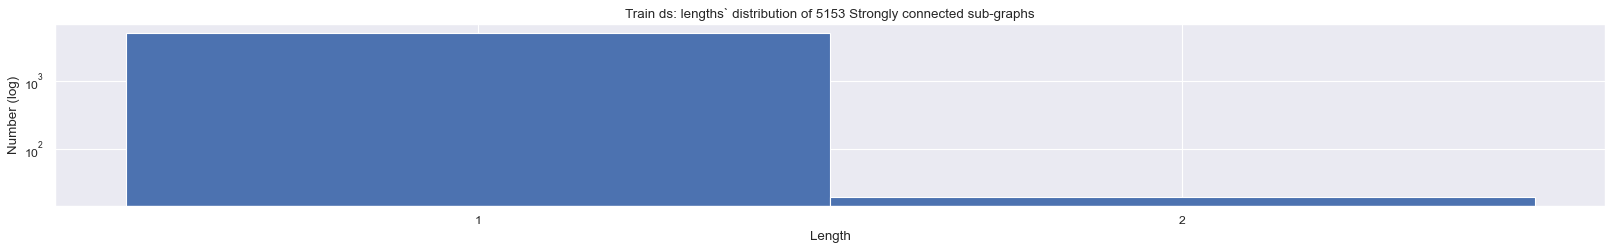

In [80]:
plot_bars_uniques(sub_graphs_strongly_valid_lengths, y_log=True, title=f'Train ds: lengths` distribution of {len(sub_graphs_strongly_valid_lengths)} Strongly connected sub-graphs')

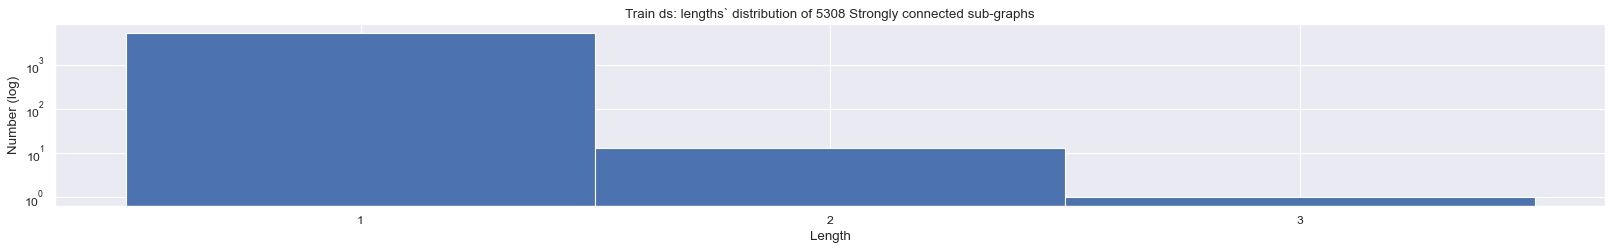

In [81]:
plot_bars_uniques(sub_graphs_strongly_test_lengths, y_log=True, title=f'Train ds: lengths` distribution of {len(sub_graphs_strongly_test_lengths)} Strongly connected sub-graphs')

In [82]:
print('There is a large subgraph os strongly-connected nodes 13806 elements. (~33$ of original graph length)')
print(f'{sub_graphs_strongly_train_lengths[0]}')

There is a large subgraph os strongly-connected nodes 13806 elements. (~33$ of original graph length)
13806


### Let's plot Largest strongly connected subgraph

In [83]:
# PROTOTYPE
# def diameter(G, sp=None):
#     return max(nx.eccentricity(G=G, sp=sp).values())

In [84]:
# PROTOTYPE
# to speed-up diameter computation
# def diameter_parallel(G: list, processes=None):
#     """G: list of nx subgraphs"""
#     p = Pool(processes=processes)
#     orders = [sub.order() for sub in G]
#     def diameter(G, sp):
#         return max(nx.eccentricity(G=G, sp=sp))
#     list_divisor = len(p._pool) * 4 # 64 * 4
#     list_chunks = list(chunks(G, int(len(G) / node_divisor)))
#     num_chanks = len(node_chunks)
#     diameter_iter = p.starmap(
#             diameter,
#             zip([G]*num_chunks,
#             sp)
#         )
#     return diameter_iter

In [85]:
stats_path = Path(os.getcwd())/'Datasets'/'wn18rr'/'stats'
if not os.path.isdir(stats_path):
    os.mkdir(stats_path)
diam_file_paths = [
    stats_path/'diameter_weakly_train.txt',
    stats_path/'diameter_weakly_valid.txt',
    stats_path/'diameter_weakly_test.txt',
    stats_path/'diameter_strong_train.txt',
    stats_path/'diameter_strong_valid.txt',
    stats_path/'diameter_strong_test.txt',
]
# Read files if present in the directory
diam_files = [None] * 6
diameters_weakly_train, diameters_weakly_valid, diameters_weakly_test = None, None, None
diameters_strongly_train, diameters_strongly_valid, diameters_strongly_test = None, None, None
for idx, file in enumerate(diam_file_paths):
    if os.path.isfile(file):
        diam_files[idx] = [int(line) for line in read_file(file)]
diameters_weakly_train, diameters_weakly_valid, diameters_weakly_test, diameters_strongly_train, diameters_strongly_valid, diameters_strongly_test = diam_files

In [86]:
%%time
# Diameter can only be computed on either unidirectional graph, or strongly-connected directional graph
if not diameters_weakly_train:
    %time diameters_weakly_train = [nx.diameter(subg.to_undirected()) for subg in sub_graphs_weakly_train]
if not diameters_weakly_valid:
    %time diameters_weakly_valid = [nx.diameter(subg.to_undirected()) for subg in sub_graphs_weakly_valid]
if not diameters_weakly_test:
    %time diameters_weakly_test = [nx.diameter(subg.to_undirected()) for subg in sub_graphs_weakly_test]
if not diameters_strongly_train:
    %time diameters_strongly_train = [nx.diameter(subg) for subg in sub_graphs_strongly_train]
if not diameters_strongly_valid:
    %time diameters_strongly_valid = [nx.diameter(subg) for subg in sub_graphs_strongly_valid]
if not diameters_strongly_test:
    %time diameters_strongly_test = [nx.diameter(subg) for subg in sub_graphs_strongly_test]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


In [87]:
force = True
diam_files = [
    stats_path/'diameter_weakly_train.txt',
    stats_path/'diameter_weakly_valid.txt',
    stats_path/'diameter_weakly_test.txt',
    stats_path/'diameter_strong_train.txt',
    stats_path/'diameter_strong_valid.txt',
    stats_path/'diameter_strong_test.txt',
]
write_file(path=diam_files[0], to_file=diameters_weakly_train, force=force)
write_file(path=diam_files[1], to_file=diameters_weakly_valid, force=force)
write_file(path=diam_files[2], to_file=diameters_weakly_test, force=force)
write_file(path=diam_files[3], to_file=diameters_strongly_train, force=force)
write_file(path=diam_files[4], to_file=diameters_strongly_valid, force=force)
write_file(path=diam_files[5], to_file=diameters_strongly_test, force=force)

In [88]:
# Re-run with enough resources
# %time diameters_strongly_train = [nx.diameter(subg) for subg in sub_graphs_strongly_train]

In [89]:
print(f'{"Diameter Weakly Train: ":30}{max(diameters_weakly_train)}')
print(f'{"Diameter Weakly Valid: ":30}{max(diameters_weakly_valid)}')
print(f'{"Diameter Weakly Test: ":30}{max(diameters_weakly_test)}')
print()
print(f'{"Diameter Strongly Train: ":30}{max(diameters_strongly_train)}')
print(f'{"Diameter Strongly Valid: ":30}{max(diameters_strongly_valid)}')
print(f'{"Diameter Strongly Test: ":30}{max(diameters_strongly_test)}')


Diameter Weakly Train:        22
Diameter Weakly Valid:        10
Diameter Weakly Test:         6

Diameter Strongly Train:      40
Diameter Strongly Valid:      1
Diameter Strongly Test:       2


|Graph|Diameter|
|:---|:------:|
|Train Weakly|22|
|Valid Weakly|10|
|Test Weakly|6|
|---------------|------|
|Train Strongly|40|
|Valid Strongly|1|
|Test Strongly|2|


### Graph diameter is 40 when considered Strongly connected graph (path in both directions for each pair of nodes)
### Graph diameter is 22 when considered Weakly connected graph (non-directed connection in at least one direction)

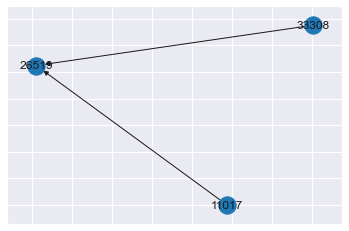

In [90]:
# Example sub-graph Weakly connected Drawn with native Matplotlib tools
nx.draw_networkx(sub_graphs_weakly_train[11])

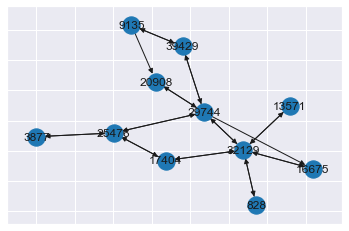

In [91]:
# Example sub-graph Strongly connected
nx.draw_networkx(sub_graphs_strongly_train[20])

In [92]:
# Example sub-graph Strongly
# Graph of One node is considered a uni-directional or directed graph, of length 1, diameter 0
# print(f'{"Subgraph of length: "}{sub_graphs_strongly_train_lengths[11]}')
# print(f'{"And diameter: "}{nx.diameter(test_G)}')
# nx.draw_networkx(test_G)

In [93]:
# graph_test_uni = graph_test.to_undirected()
# sub_graphs_unidir = [graph_test_uni.subgraph(nodes) for nodes in nx.connected_components(graph_test_uni)]

In [94]:
# NOTE Compute Clique -- complete subgraphs
# Clique = subgraph where all vertex are strongly connected to all others

In [95]:
# NOTE Compute K neighbors -- compute degree of graph connectiveness
# Use k-neighbor connectiveness

## Export graph to a file to open in 3rd party software

In [96]:
# Graph export for Gephi
# NOTE Uncomment to export
# ds_train_exp = [(ds.id2entity[src], ds.id2entity[dst], {'label':ds.id2relation[list(rel.keys())[0]]}) for src, dst, rel in ds_train]
# graph_train_exp = DirectedGraph(ds_train_exp)
# nx.write_gexf(graph_train_exp, 'train.gexf')

In [97]:
# Graph export to json (e.g. for D3 js library)
# NOTE Uncomment to export
# import json
# ds_train_exp = [(ds.id2entity[src], ds.id2entity[dst], {'label':ds.id2relation[list(rel.keys())[0]]}) for src, dst, rel in ds_train]
# graph_train_exp = DirectedGraph(ds_train_exp)
# d3_data = nx.node_link_data(graph_train_exp)
# with open('graph_train_d3.json', 'w') as f:
#     json.dump(d3_data, f)

# Augment dataset (Graph) to have an oposite relation for each relation

In [98]:
# Dictionary of relations
ds.id2relation

{0: '_instance_hypernym',
 1: '_hypernym',
 2: '_derivationally_related_form',
 3: '_synset_domain_topic_of',
 4: '_similar_to',
 5: '_member_meronym',
 6: '_has_part',
 7: '_member_of_domain_usage',
 8: '_verb_group',
 9: '_also_see',
 10: '_member_of_domain_region'}

Two possible strategies for dataset augmentation:  
1. Double number of relations by creating r' for each r in R such that r' is oposite to r,  
2. Manually creating dictionary of oposite relations when each relation semantic value is available.
3. Mixed strategy where some relations are takes from the available dictionary, and some are created  

For strategy #1, number of relation labels doubles. OH vector of relations doubles.  
For strategy #2, number of relation labels remains the same.  
For strategy #3, number of relations is increased to < 2*N, where N is initial number of relations in the dataset.  
Problem with strategies 1,2 :  
For relations prediction task, if model predict a relation r' (oposite to r), that doesn't in the original dataset,
it's prediciton only implies that there is probably a relation r in oposite direction. But the prediction r' cannot be exploited to improve the score.
Thus, only strategy 3 can directly improve the model by adding more symantics to the relation labels.

Below provided dataset aumentation proposal without creation of new relations.
4 existing symetric relations are reused.

Augmentation strategy: since for strategies 1,2 all the graph must be updated (relation vectors and possible relation indexes), it's suggested to updated the dataset before creating the graph.
Thus, dataset becomes loaded into memory, a real hashable structure.

There is not point of storing label tensor in the Graph. It can be just key with empty data. Label universe is always used to retrive tensors.

In [103]:
relation2id_augmented, relation_id2vec_augmented, revers_rels = create_revers_rels(relation_revers, ds.relation2id)

In [104]:
graph_train_augment = graph_train.copy()

In [105]:
augment_graph(graph_train_augment, revers_rels)

In [107]:
print(nx.info(graph_train))

Name: 
Type: DirectedGraph
Number of nodes: 40714
Number of edges: 86719
Average in degree:   2.1300
Average out degree:   2.1300


In [108]:
print(nx.info(graph_train_augment))

Name: 
Type: DirectedGraph
Number of nodes: 40714
Number of edges: 89238
Average in degree:   2.1918
Average out degree:   2.1918


After augmentation 89238-86719 = 2519 edges were added

# Draw and explore graphs

On keeping realtion vectors in the graph: 

In [99]:
def explore_relations(list_triples: list, relation: str, num = 30):
    for src, dst, rel in list_triples:
        rel_str = list(rel.values())[0]
        if (rel_str == relation):
            print(f'{src:20} -- {rel_str:15} -> {dst}')
            num -= 1
        if not num:
            break

Relations sorted by frequency   
'_hypernym': 34796,  
'_derivationally_related_form': 29715,  
'_member_meronym': 7402,  
'_has_part': 4816,  
'_synset_domain_topic_of': 3116,  
'_instance_hypernym': 2921,  
'_also_see': 1299,  
'_verb_group': 1138,  
'_member_of_domain_region': 923,  
'_member_of_domain_usage': 629,  
'_similar_to': 80  

In [100]:
# graph_train_draw_list = list(format_for_drawing(graph_train, id2entity=ds.id2entity, id2relation=ds.id2relation))

In [101]:
relation_revers = {
    # sorted by frequency
    # asymetric. super<>sub-ordinate
    '_hypernym': None, # super-sub-ordinate. inheritble. meta-class. Oposit to hyponym !INVERTED!
    # symetric
    '_derivationally_related_form': '_derivationally_related_form', # https://stackoverflow.com/questions/39707654/what-are-derivationally-related-forms-in-wordnet
    # asymetric. whole<>part relations
    # '_member_meronym': '_has_part', # finger is meronym of hand. oposite to holonym (set constituted of heronyms) !INVERTED!
    '_member_meronym': None, # finger is meronym of hand. oposite to holonym (set constituted of heronyms) !INVERTED!
    # '_has_part': '_member_meronym', # oposite to meronym meronym, hand has_part finger. same as holonym. Since _member_meronym is inverted, cannot be used.
    '_has_part': None, # oposite to meronym meronym, hand has_part finger. same as holonym. Since _member_meronym is inverted, cannot be used.
    # asymetric. member<>topic
    '_synset_domain_topic_of': None, # not symetrical relation. e.g wave _synset_domain_topic_of physics. But physics is not topic of wave. oposite should be a domain.
    # asymetric. super<>sub-ordinate
    '_instance_hypernym' : None, # meta-class of an instance of something. !INVERTED!
    # symetric
    '_also_see': '_also_see',
    '_verb_group': '_verb_group',
    # asymetric. member<>domain
    '_member_of_domain_usage': None, # !INVERTED!
    '_member_of_domain_region': None, # !INVERTED!
    #symetric
    '_similar_to': '_similar_to',
}

In [ ]:
print(nx.info(graph_train_augment))

In [ ]:
print(nx.info(graph_train_augment))

In [ ]:
%%time
augment_graph(graph_train_augment, revers_rels_ids)

In [ ]:
G = format_for_drawing(graph, id2entity=ds.id2entity, id2relation=id2relation_augmented_1)
plotter.plot(G)

In [ ]:
G = format_for_drawing(graph_test)
plotter.plot(G)

In [ ]:
G = format_for_drawing(graph_valid)
plotter.plot(G)